In [2]:
import os 
import cebra
from cebra import CEBRA
import pandas as pd
import tables
import sys
import matplotlib.pyplot as plt

1. Load all S_aligned files and save them as hdf5

In [ ]:
path = '/Users/annateruel/Desktop/results_calcium/AD22092'

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('S_aligned.csv'):
            file_path = os.path.join(root, file)  # Get the full path to the CSV file
            # Use a key based on the relative path of the CSV file to store it in the dictionary
            key = os.path.relpath(file_path, path).replace('S_aligned.csv', '').replace(os.path.sep, '_')

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            df = df.drop('frame', axis=1)
            df = (df>0).astype(int) #converting all numbers above 0 to 1, so that our spikes are boolean

            # Define the path to save the HDF5 file in the same directory with the same name
            h5_file_path = os.path.splitext(file_path)[0] + '.h5'

            # Save the DataFrame as an HDF5 file in the same directory
            df.to_hdf(h5_file_path, key='data', mode='w')
            
            print(f"Converted '{file}' to '{os.path.basename(h5_file_path)}' and saved in '{os.path.dirname(h5_file_path)}'")

2. Create a dictionary storing info from 4 different hdf5 files. Each file belongs to a different session. Total number of sessions: 4. 

In [ ]:
import numpy as np
t = pd.read_hdf('/Users/annateruel/Desktop/results_calcium/AD22118/session2/S_aligned.h5')
t

In [ ]:
b = pd.read_hdf('/Users/annateruel/Desktop/results_calcium/AD22092/session2/centroid.h5')
b

In [ ]:
path = '/Users/annateruel/Desktop/results_calcium/AD22118'
data = {}  # Create a dictionary to store data from each CSV file

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('S_aligned.csv'):
            file_path = os.path.join(root, file)  # Get the full path to the CSV file
            # Use a key based on the relative path of the CSV file to store it in the dictionary
            key = os.path.relpath(file_path, path).replace('S_aligned.csv', '').replace(os.path.sep, '_')
            data[key] = pd.read_csv(file_path)


In [ ]:
import numpy as np
nd = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/hab2/session2/S_aligned.h5')
b = cebra.load_data(file='/Users/annateruel/Desktop/results_calcium/AD22092/session2/centroid.h5')



### CEBRA-time 
Uses time without behaviour information

In [ ]:
max_iterations = 10000 

cebra_time_model = CEBRA(model_architecture='offset10-model',  #CEBRA TIME model
                        batch_size=512,
                        learning_rate=0.05,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='mps',
                        verbose=True,
                        time_offsets=10)

In [ ]:
cebra_time_model.fit(nd) #training
cebra_time_model.save("cebra_time_model_ad22092_s4.pt")

In [ ]:
cebra_time_model = cebra.CEBRA.load("cebra_time_model_ad22092_s2.pt")
cebra_time = cebra_time_model.transform(nd)

In [ ]:
cebra.plot_embedding(embedding=cebra_time, embedding_labels=b[:,0], title='CEBRA-Behavior_s1', cmap='cebra', dpi = 200, markersize= 1)

In [ ]:
fig = plt.figure(figsize=(20,5))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')

ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_time, embedding_labels=nd_s4[:,4], title='CEBRA-Time Session4')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_time, embedding_labels=nd_s4[:,50], title='CEBRA-Time Session4')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_time, embedding_labels=nd_s4[:,1], title='CEBRA-Time Session4')




### CEBRA-behavior

Train a model that uses positional (pose estimation) information

Now we
 want to run CEBRA BEHAVIOR, thus we need to use as labels our behavior from dlc, which are different h5 files. To do so, we need to merge with `pd.merge` all h5 files from dlc, because since during the recoridng we save a video every 1000 frames, we need to get one single file.

In [ ]:
h5_dir = '/Volumes/ANNA_HD/ANALYSIS/minian/AD22-118/'

for session_dir in os.listdir(h5_dir):
    session_path = os.path.join(h5_dir, session_dir)
    
    # Check if the item in the root directory is a directory itself
    if os.path.isdir(session_path):
        dlc_output_dir = os.path.join(session_path, 'dlc')  # Path to "dlc" output directory
        
        if os.path.exists(dlc_output_dir) and os.path.isdir(dlc_output_dir):
            # Initialize an empty list to store DataFrames for this session
            dataframes = []
            
            # Loop through h5 files in the "dlc" output directory
            for h5_file in os.listdir(dlc_output_dir):
                if h5_file.startswith("._"):
                    file_path = os.path.join(dlc_output_dir, h5_file)
                    os.remove(file_path)
                elif h5_file.endswith('filtered.h5'):
                    h5_file_path = os.path.join(dlc_output_dir, h5_file)

                    # Read the h5 file into a DataFrame
                    df = pd.read_hdf(h5_file_path)
                    # Append the DataFrame to the list
                    dataframes.append(df)
            
            if dataframes:
                # Merge all DataFrames in this session into a single DataFrame
                merged_df = pd.concat(dataframes, axis=0)
                
                # Define the path to save the merged h5 file in the session directory
                output_h5_path = os.path.join(session_path, 'merged_output.h5')
                
                # Save the merged DataFrame as an h5 file
                merged_df.to_hdf(output_h5_path, key='data', mode='w')
                
                print(f"Merged data saved to '{output_h5_path}' in session '{session_dir}'")
        



Calculate the centroid, to use centroid position in space as your label, because we're interested in position among space. 

In [ ]:
behavior = pd.read_hdf('/Users/annateruel/Desktop/results_calcium/AD22092/session1/merged_output.h5')
df = behavior.loc[:,('DLC_resnet50_ca2+imgJan30shuffle1_500000')]
df['x_centroid'] = np.mean(df.loc[:,(slice(None), 'x')], axis=1)
df['y_centroid'] = np.mean(df.loc[:,(slice(None), 'y')], axis=1)
df2 = df[['x_centroid', 'y_centroid']]
df2.to_hdf('/Users/annateruel/Desktop/results_calcium/AD22092/session1/centroid.h5', key='data', mode='w')

In [28]:
import numpy as np
nd = cebra.load_data(file='/Users/annateruel/Desktop/poster fens/AD23-120/test1/caiman/aligned_C.h5')
b = cebra.load_data(file='/Users/annateruel/Desktop/poster fens/AD23-120/test1/CEBRA/labels.h5')


In [29]:
b = b[:len(nd)]

# Verify the lengths
print(f"Length of nd: {len(nd)}")
print(f"Length of b: {len(b)}")

Length of nd: 2305
Length of b: 2305


'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

In [84]:
max_iterations = 5000

cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=1024,
                        learning_rate=0.01,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        num_hidden_units = 16,
                        distance='cosine',
                        device='mps',
                        verbose=True,
                        time_offsets=1)

In [85]:
cebra_behavior_model.fit(nd, b[:,0])
cebra_behavior_model.save('/Users/annateruel/Desktop/AD23-120/hab2/CEBRA/cebramodelcaiman.pt')


pos: -0.9519 neg:  7.1028 total:  6.1510 temperature:  1.0000: 100%|██████████| 5000/5000 [10:41<00:00,  7.80it/s]


In [30]:
cebra_behavior_model = cebra.CEBRA.load('/Users/annateruel/Desktop/poster fens/AD23-120/test1/CEBRA/cebramodelcaiman.pt')
cebra_behavior = cebra_behavior_model.transform(nd)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class ROI:
    def __init__(self, center, rad):
        self.center = center
        self.rad = rad

    def is_point_inside_roi(self, point):
        """
        Determines if a given point is inside the ellipse.

        Args:
            point (tuple): A tuple representing the (x, y) coordinates of the point to check.

        Returns:
            bool: True if the point is inside the ellipse, False otherwise.
        """        
        x, y = point
        h, k = self.center
        a, b = self.rad
        return ((x - h)**2 / a**2) + ((y - k)**2 / b**2) <= 1

def load_roi_data(roi_file):
    roi_data = pd.read_hdf(roi_file)
    print("ROI Data Structure:")
    print(roi_data.head())  # Print a sample of the data for inspection
    return roi_data

def compute_roi_parameters(x, y, w, h):
    """
    Compute the center and radii of an ellipse from manual coordinates.

    Args:
        x (int): The x-coordinate of the top-left corner.
        y (int): The y-coordinate of the top-left corner.
        w (int): The width of the rectangle.
        h (int): The height of the rectangle.

    Returns:
        center (tuple): The (x, y) coordinates of the ellipse center.
        rad (tuple): The (a, b) radii of the ellipse.
    """
    center_x = x + w / 2
    center_y = y + h / 2
    a = w / 2
    b = h / 2
    
    return (center_x, center_y), (a, b)

def plot_data_with_rois(roi_data, rois):
    """
    Plot the data points with different colors based on the ROI.

    Args:
        roi_data (DataFrame): The data points to be plotted.
        rois (list of ROI): The list of ROI objects.
    """
    colors = ['blue', 'red', 'green', 'purple']  # Add more colors if you have more ROIs
    plt.figure(figsize=(10, 8))
    
    for index, row in roi_data.iterrows():
        point = (row['axis-0'], row['axis-1'])
        color = 'gray'  # Default color for points not in any ROI
        for i, roi in enumerate(rois):
            if roi.is_point_inside_roi(point):
                color = colors[i % len(colors)]
                break
        plt.scatter(point[0], point[1], color=color)
    
    for roi in rois:
        ellipse = plt.Circle(roi.center, roi.rad[0], roi.rad[1], color='black', fill=False)
        plt.gca().add_patch(ellipse)

    plt.xlabel('Axis-0')
    plt.ylabel('Axis-1')
    plt.title('Data Points with ROIs')
    plt.show()

# Manual coordinates for ROIs
roi0_center, roi0_radii = compute_roi_parameters(158, 125, 109, 102)
roi1_center, roi1_radii = compute_roi_parameters(144, 340, 119, 116)

roi0 = ROI(roi0_center, roi0_radii)
roi1 = ROI(roi1_center, roi1_radii)

rois = [roi0, roi1]

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_cebra_behavior(cebra_behavior, labels, output_path=None, roi0=None, roi1=None, elev=30, azim=45, axis_order=(0, 1, 2), save_fig=False):
    # Apply axis order to the data
    x = cebra_behavior[:, axis_order[0]]
    y = cebra_behavior[:, axis_order[1]]
    z = cebra_behavior[:, axis_order[2]]

    # Define ROI conditions for plotting
    if roi0 is not None and roi1 is not None:
        in_roi0 = [roi0.is_point_inside_roi((point[0], point[1])) for point in labels]
        in_roi1 = [roi1.is_point_inside_roi((point[0], point[1])) for point in labels]

        # Debugging: Check number of points in each ROI
        print(f"Points in ROI0: {sum(in_roi0)}, Points in ROI1: {sum(in_roi1)}")

        # Debugging: Print some points to verify correctness
        for i, (point, roi0_flag, roi1_flag) in enumerate(zip(labels, in_roi0, in_roi1)):
            if i < 10 or roi1_flag:  # Print first 10 points and any point in ROI1
                print(f"Point {i}: {point}, in ROI0: {roi0_flag}, in ROI1: {roi1_flag}")

    # Plotting code
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['gray'] * len(cebra_behavior)
    if roi0 is not None and roi1 is not None:
        for idx, in_roi in enumerate(in_roi0):
            if in_roi:
                colors[idx] = 'deepskyblue'
        for idx, in_roi in enumerate(in_roi1):
            if in_roi:
                colors[idx] = 'magenta'

    scatter = ax.scatter(x, y, z, c=colors, alpha=0.5, s=20)

    # Rotate the view
    ax.view_init(elev=elev, azim=azim)
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('white')
    ax.yaxis.pane.set_edgecolor('white')
    ax.zaxis.pane.set_edgecolor('white')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)

    fig.patch.set_facecolor('#17171D')
    ax.set_facecolor('#17171D')

    plt.title('3D Embedding Space with ROIs Highlighted')
    ax.set_xlabel('Embedding Dim 1')
    ax.set_ylabel('Embedding Dim 2')
    ax.set_zlabel('Embedding Dim 3')

    if save_fig and output_path:
        if not output_path.lower().endswith('.svg'):
            output_path = output_path.rstrip('/') + '/embedding_space_with_rois.svg'
        plt.savefig(output_path, format='svg', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    else:
        plt.show()


Points in ROI0: 521, Points in ROI1: 0
Point 0: [691.72094727 218.39809875   0.           0.        ], in ROI0: False, in ROI1: False
Point 1: [691.70425372 218.36284777   1.           2.        ], in ROI0: False, in ROI1: False
Point 2: [695.94501483 221.41342896   2.           3.        ], in ROI0: False, in ROI1: False
Point 3: [700.82763015 219.31632712   3.           5.        ], in ROI0: False, in ROI1: False
Point 4: [702.93810628 218.13087093   4.           7.        ], in ROI0: False, in ROI1: False
Point 5: [704.19550169 218.97080955   5.           8.        ], in ROI0: False, in ROI1: False
Point 6: [705.53907589 219.57876989   6.          10.        ], in ROI0: False, in ROI1: False
Point 7: [707.06452164 217.31642072   7.          12.        ], in ROI0: False, in ROI1: False
Point 8: [706.29677759 216.11414251   8.          13.        ], in ROI0: False, in ROI1: False
Point 9: [706.66627822 215.78810691   9.          15.        ], in ROI0: False, in ROI1: False


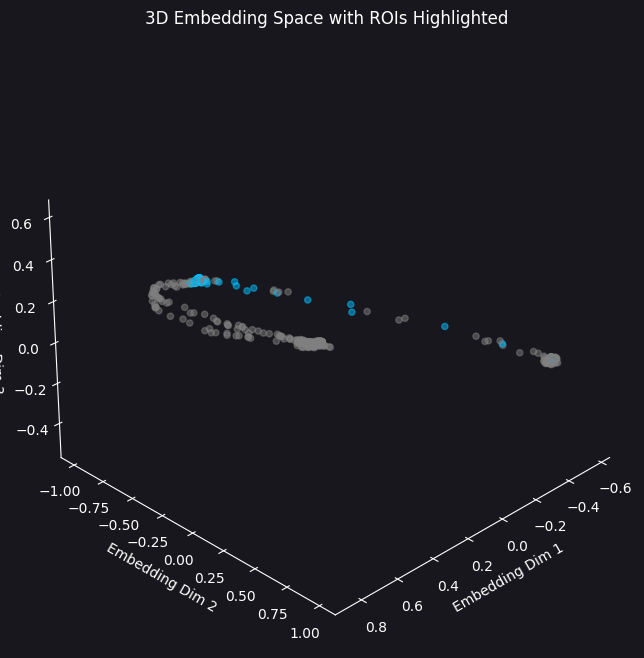

In [39]:
plot_cebra_behavior(cebra_behavior, b, '/Users/annateruel/Desktop/embedding_space_with_rois.svg', roi0, roi1, axis_order=(0, 1, 2), save_fig=True)

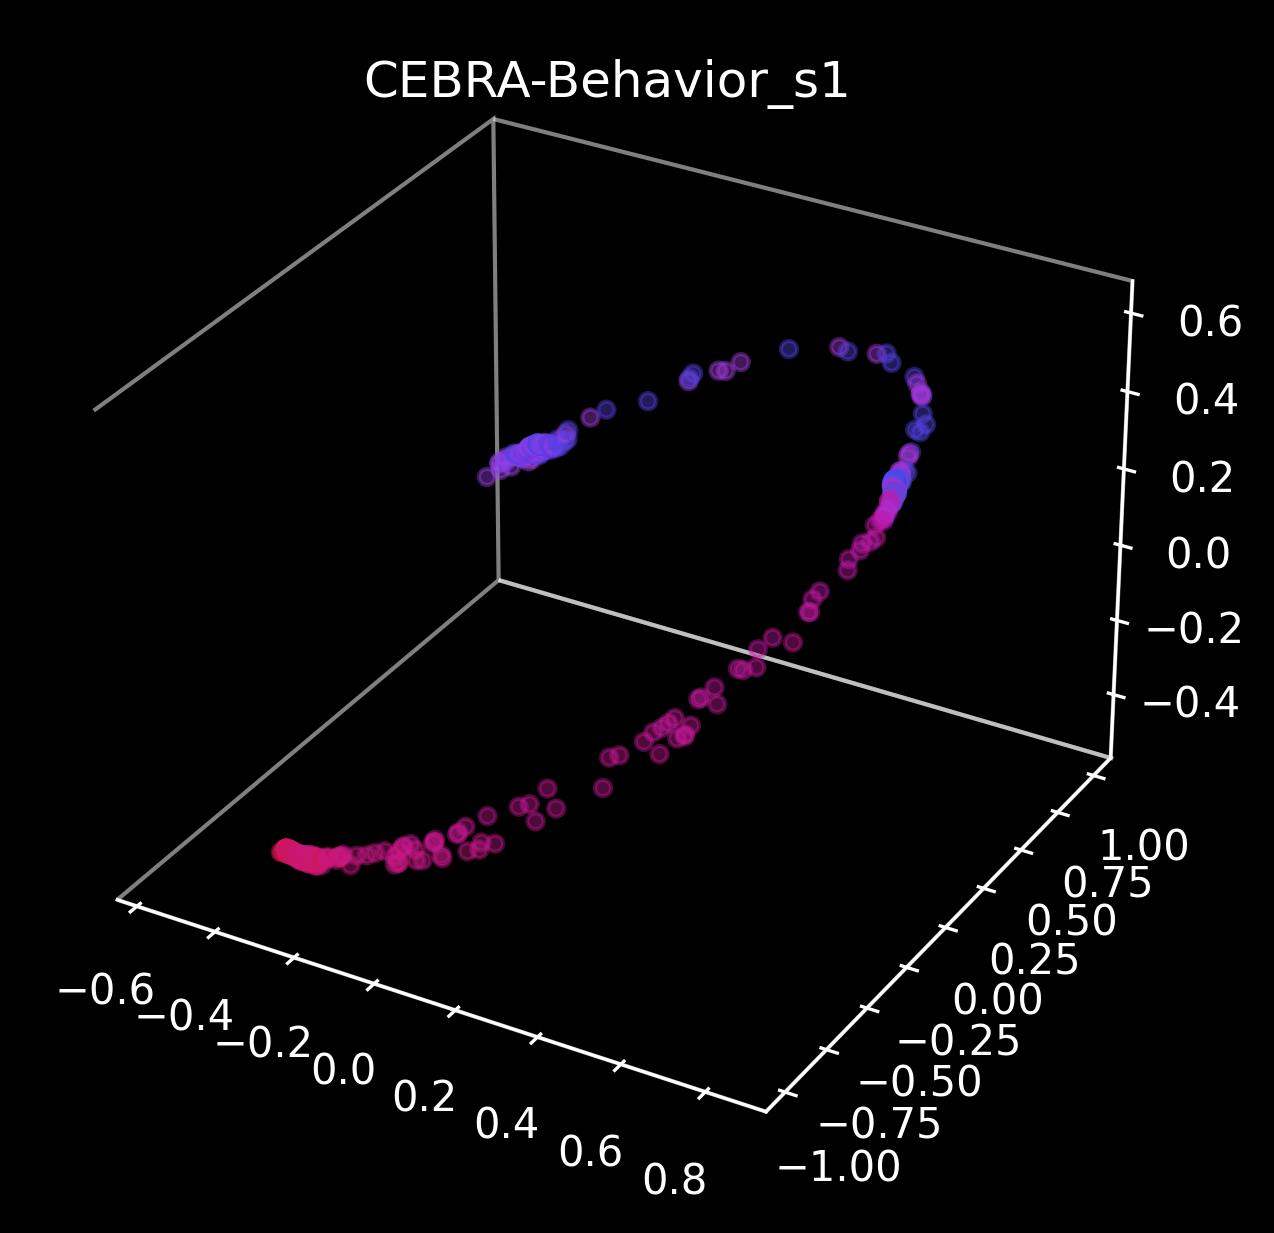

In [31]:
plt.style.use('dark_background')  # plots with black background
cebra.plot_embedding(embedding=cebra_behavior, embedding_labels=b[:,0], title='CEBRA-Behavior_s1', cmap='cebra', dpi = 300, markersize= 15)
plt.savefig('/Users/annateruel/Desktop/test_12m.svg', format='svg')

# CONSISTENCY

In [90]:
#ALZhab2 AD23-120
alzhab2 = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/hab2/caiman/aligned_C.h5')
b_alzhab2 = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/hab2/CEBRA/labels.h5')
cebra_behavior_model = cebra.CEBRA.load('/Users/annateruel/Desktop/AD23-120/hab2/CEBRA/cebramodelcaiman.pt')
model_alzhab2 = cebra_behavior_model.transform(alzhab2)

In [92]:
#ALZtrn1 AD23-120
alztrn1 = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/trn1/caiman/aligned_C.h5')
b_alztrn1 = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/trn1/CEBRA/labels.h5')
cebra_behavior_model = cebra.CEBRA.load('/Users/annateruel/Desktop/AD23-120/trn1/CEBRA/cebramodelcaiman.pt')
model_alztrn1 = cebra_behavior_model.transform(alztrn1)

In [94]:
#ALZtrn1 AD23-120
alztest = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/test1/caiman/aligned_C.h5')
b_alztest = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/test1/CEBRA/labels.h5')
cebra_behavior_model = cebra.CEBRA.load('/Users/annateruel/Desktop/AD23-120/test1/CEBRA/cebramodelcaiman.pt')
model_alztest = cebra_behavior_model.transform(alztest)

Length of data (alzhab2): 2259
Length of labels (alzhab2): 2259
Shape of embeddings (alzhab2): (2259, 3)
Shape of labels (alzhab2): (2259,)
Length of data (alztrn1): 2317
Length of labels (alztrn1): 2317
Shape of embeddings (alztrn1): (2317, 3)
Shape of labels (alztrn1): (2317,)
Length of data (alztest): 2305
Length of labels (alztest): 2305
Shape of embeddings (alztest): (2305, 3)
Shape of labels (alztest): (2305,)
Consistency scores between sessions:
alzhab2 vs alztrn1: -0.057843045333112554
alzhab2 vs alztest: -0.08768257415440939
alztrn1 vs alztest: 0.042734835565581365


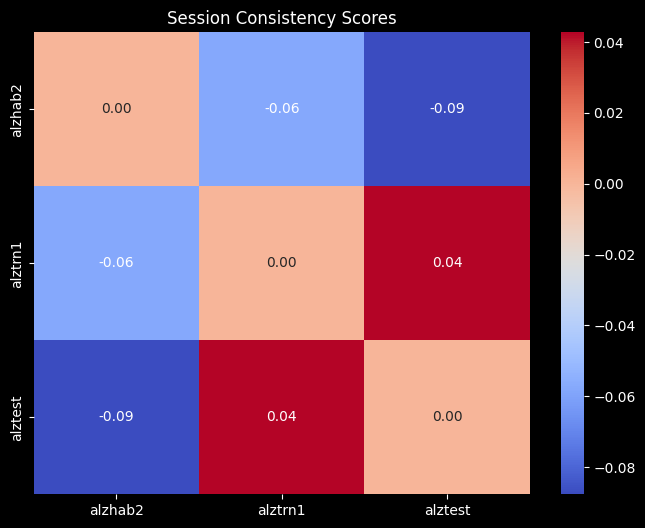

In [119]:
import cebra
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load data and transform using CEBRA models
data_files = {
    "alzhab2": {
        "data": "/Users/annateruel/Desktop/AD23-120/hab2/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD23-120/hab2/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD23-120/hab2/CEBRA/cebramodelcaiman.pt"
    },
    "alztrn1": {
        "data": "/Users/annateruel/Desktop/AD23-120/trn1/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD23-120/trn1/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD23-120/trn1/CEBRA/cebramodelcaiman.pt"
    },
    "alztest": {
        "data": "/Users/annateruel/Desktop/AD23-120/test1/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD23-120/test1/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD23-120/test1/CEBRA/cebramodelcaiman.pt"
    }
}

models = {}
embeddings = {}
labels = {}

for session, paths in data_files.items():
    data = cebra.load_data(file=paths["data"])
    session_labels = cebra.load_data(file=paths["labels"])
    
    # Trim labels to match the length of data if necessary
    min_samples = min(data.shape[0], session_labels.shape[0])
    data = data[:min_samples]
    session_labels = session_labels[:min_samples]
    
    labels[session] = session_labels[:, 0].astype(float)  # Ensure labels are 1D floats
    model = cebra.CEBRA.load(paths["model"])
    models[session] = model
    embeddings[session] = model.transform(data)
    
    # Verify the lengths and shapes
    print(f"Length of data ({session}): {len(data)}")
    print(f"Length of labels ({session}): {len(session_labels)}")
    print(f"Shape of embeddings ({session}): {embeddings[session].shape}")
    print(f"Shape of labels ({session}): {labels[session].shape}")

# Function to compute the correlation between two sets of embeddings
def compute_session_consistency(embedding1, embedding2):
    min_length = min(embedding1.shape[0], embedding2.shape[0])
    embedding1 = embedding1[:min_length]
    embedding2 = embedding2[:min_length]
    
    correlations = []
    for i in range(embedding1.shape[1]):
        corr, _ = pearsonr(embedding1[:, i], embedding2[:, i])
        correlations.append(corr)
    return np.mean(correlations)

# Compute consistency between all pairs of sessions
session_keys = list(embeddings.keys())
consistency_scores = {}

for i in range(len(session_keys)):
    for j in range(i + 1, len(session_keys)):
        session1 = session_keys[i]
        session2 = session_keys[j]
        score = compute_session_consistency(embeddings[session1], embeddings[session2])
        consistency_scores[(session1, session2)] = score

# Print the results
print("Consistency scores between sessions:")
for (session1, session2), score in consistency_scores.items():
    print(f"{session1} vs {session2}: {score}")

# Create a matrix for visualization
consistency_matrix = np.zeros((len(session_keys), len(session_keys)))
for (session1, session2), score in consistency_scores.items():
    i = session_keys.index(session1)
    j = session_keys.index(session2)
    consistency_matrix[i, j] = score
    consistency_matrix[j, i] = score

plt.figure(figsize=(8, 6))
sns.heatmap(consistency_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=session_keys, yticklabels=session_keys)
plt.title("Session Consistency Scores")
plt.show()



Length of data (alzhab2): 3249
Length of labels (alzhab2): 3249
Shape of embeddings (alzhab2): (3249, 3)
Shape of labels (alzhab2): (3249,)
Length of data (alztrn1): 3253
Length of labels (alztrn1): 3253
Shape of embeddings (alztrn1): (3253, 3)
Shape of labels (alztrn1): (3253,)
Length of data (alztest): 3251
Length of labels (alztest): 3251
Shape of embeddings (alztest): (3251, 3)
Shape of labels (alztest): (3251,)
Consistency scores between sessions:
alzhab2 vs alztrn1: 0.0031003827248717863
alzhab2 vs alztest: 0.17395203182050945
alztrn1 vs alztest: -0.1032062034684843


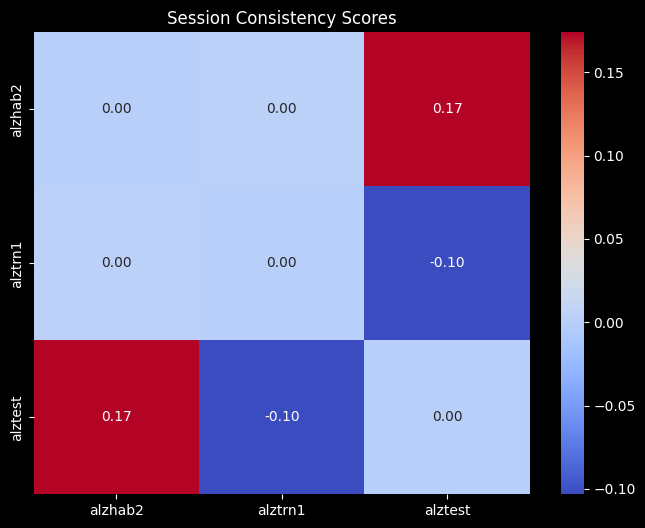

In [121]:
data_files = {
    "alzhab2": {
        "data": "/Users/annateruel/Desktop/AD22-118/hab2/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/hab2/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/hab2/CEBRA/cebramodelcaiman.pt"
    },
    "alztrn1": {
        "data": "/Users/annateruel/Desktop/AD22-118/trn1/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/trn1/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/trn1/CEBRA/cebramodelcaiman.pt"
    },
    "alztest": {
        "data": "/Users/annateruel/Desktop/AD22-118/test/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/test/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/test/CEBRA/cebramodelcaiman.pt"
    }
}

models = {}
embeddings = {}
labels = {}

for session, paths in data_files.items():
    data = cebra.load_data(file=paths["data"])
    session_labels = cebra.load_data(file=paths["labels"])
    
    # Trim labels to match the length of data if necessary
    min_samples = min(data.shape[0], session_labels.shape[0])
    data = data[:min_samples]
    session_labels = session_labels[:min_samples]
    
    labels[session] = session_labels[:, 0].astype(float)  # Ensure labels are 1D floats
    model = cebra.CEBRA.load(paths["model"])
    models[session] = model
    embeddings[session] = model.transform(data)
    
    # Verify the lengths and shapes
    print(f"Length of data ({session}): {len(data)}")
    print(f"Length of labels ({session}): {len(session_labels)}")
    print(f"Shape of embeddings ({session}): {embeddings[session].shape}")
    print(f"Shape of labels ({session}): {labels[session].shape}")

# Function to compute the correlation between two sets of embeddings
def compute_session_consistency(embedding1, embedding2):
    min_length = min(embedding1.shape[0], embedding2.shape[0])
    embedding1 = embedding1[:min_length]
    embedding2 = embedding2[:min_length]
    
    correlations = []
    for i in range(embedding1.shape[1]):
        corr, _ = pearsonr(embedding1[:, i], embedding2[:, i])
        correlations.append(corr)
    return np.mean(correlations)

# Compute consistency between all pairs of sessions
session_keys = list(embeddings.keys())
consistency_scores = {}

for i in range(len(session_keys)):
    for j in range(i + 1, len(session_keys)):
        session1 = session_keys[i]
        session2 = session_keys[j]
        score = compute_session_consistency(embeddings[session1], embeddings[session2])
        consistency_scores[(session1, session2)] = score

# Print the results
print("Consistency scores between sessions:")
for (session1, session2), score in consistency_scores.items():
    print(f"{session1} vs {session2}: {score}")

# Create a matrix for visualization
consistency_matrix = np.zeros((len(session_keys), len(session_keys)))
for (session1, session2), score in consistency_scores.items():
    i = session_keys.index(session1)
    j = session_keys.index(session2)
    consistency_matrix[i, j] = score
    consistency_matrix[j, i] = score

plt.figure(figsize=(8, 6))
sns.heatmap(consistency_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=session_keys, yticklabels=session_keys)
plt.title("Session Consistency Scores")
plt.show()

In [126]:
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_cca_consistency_scores(emb, dataset_ids=[]):
    """
    Computes the pairwise CCA scores for a list of embeddings.
    Args:
        emb: List of embeddings (numpy arrays).
        dataset_ids: List of dataset IDs corresponding to the embeddings.
    Returns:
        scores: List of CCA similarity scores.
        pairs: List of dataset ID pairs.
    """
    if isinstance(emb, dict):
        emb = list(emb.values())
    if len(emb) <= 1:
        raise ValueError("Provide at least 2 embeddings to compare.")
    if len(dataset_ids) == 0:
        dataset_ids = list(range(len(emb)))
    if len(emb) != len(dataset_ids):
        raise ValueError("The number of embeddings must match the number of dataset IDs.")
    
    scores = []
    pairs = []
    n_components = min([embedding.shape[1] for embedding in emb])  # Use the smallest number of components
    
    # Iterate through all pairs of embeddings
    for i in range(len(emb)):
        for j in range(i + 1, len(emb)):
            embedding1 = emb[i]
            embedding2 = emb[j]
            min_length = min(embedding1.shape[0], embedding2.shape[0])
            embedding1 = embedding1[:min_length]
            embedding2 = embedding2[:min_length]
            
            cca = CCA(n_components=n_components)
            cca.fit(embedding1, embedding2)
            X_c, Y_c = cca.transform(embedding1, embedding2)
            
            correlations = [np.corrcoef(X_c[:, k], Y_c[:, k])[0, 1] for k in range(n_components)]
            score = np.mean(correlations)
            
            scores.append(score)
            pairs.append((dataset_ids[i], dataset_ids[j]))
    
    return scores, pairs


Length of data (conhab2): 3249
Length of labels (conhab2): 3249
Shape of embeddings (conhab2): (3249, 3)
Shape of labels (conhab2): (3249,)
Length of data (contrn1): 3253
Length of labels (contrn1): 3253
Shape of embeddings (contrn1): (3253, 3)
Shape of labels (contrn1): (3253,)
Length of data (contest): 3251
Length of labels (contest): 3251
Shape of embeddings (contest): (3251, 3)
Shape of labels (contest): (3251,)


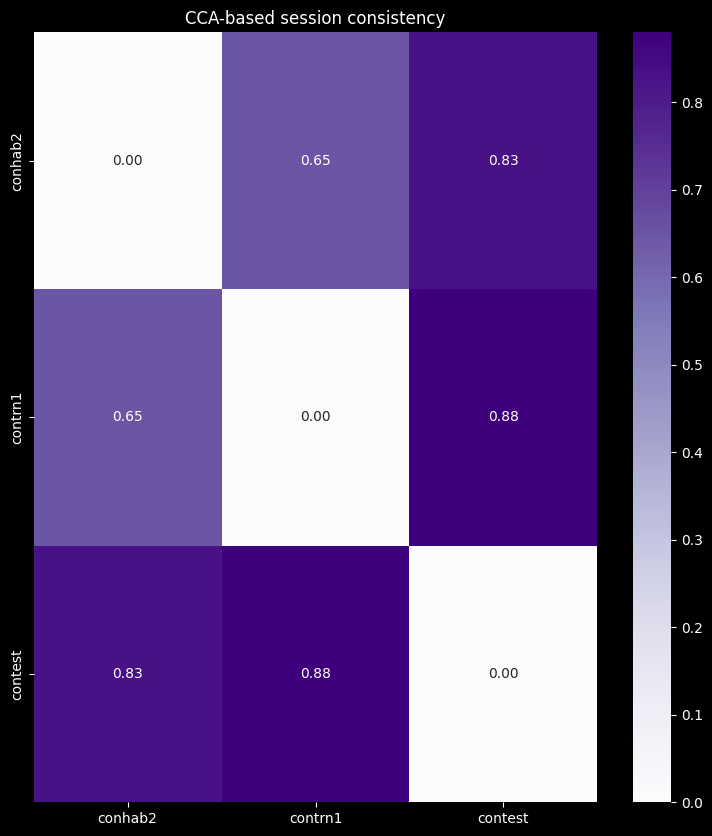

In [144]:
import cebra
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import CCA

# Load data and transform using CEBRA models
data_files = {
    "conhab2": {
        "data": "/Users/annateruel/Desktop/AD22-118/hab2/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/hab2/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/hab2/CEBRA/cebramodelcaiman.pt"
    },
    "contrn1": {
        "data": "/Users/annateruel/Desktop/AD22-118/trn1/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/trn1/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/trn1/CEBRA/cebramodelcaiman.pt"
    },
    "contest": {
        "data": "/Users/annateruel/Desktop/AD22-118/test/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/test/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/test/CEBRA/cebramodelcaiman.pt"
    }
}

models = {}
embeddings = {}
labels = {}

for session, paths in data_files.items():
    data = cebra.load_data(file=paths["data"])
    session_labels = cebra.load_data(file=paths["labels"])
    
    # Trim labels to match the length of data if necessary
    min_samples = min(data.shape[0], session_labels.shape[0])
    data = data[:min_samples]
    session_labels = session_labels[:min_samples]
    
    labels[session] = session_labels[:, 0].astype(float)  # Ensure labels are 1D floats
    model = cebra.CEBRA.load(paths["model"])
    models[session] = model
    embeddings[session] = model.transform(data)
    
    # Verify the lengths and shapes
    print(f"Length of data ({session}): {len(data)}")
    print(f"Length of labels ({session}): {len(session_labels)}")
    print(f"Shape of embeddings ({session}): {embeddings[session].shape}")
    print(f"Shape of labels ({session}): {labels[session].shape}")

# Function to compute CCA similarity between two sets of embeddings
def compute_cca_similarity(embedding1, embedding2, n_components=10):
    min_length = min(embedding1.shape[0], embedding2.shape[0])
    embedding1 = embedding1[:min_length]
    embedding2 = embedding2[:min_length]
    
    cca = CCA(n_components=n_components)
    cca.fit(embedding1, embedding2)
    X_c, Y_c = cca.transform(embedding1, embedding2)
    
    correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_components)]
    return np.mean(correlations)

# Calculate mean embeddings per label
def get_mean_per_label(embedding, label):
    unique_labels = np.unique(label)
    mean_embeddings = np.array([embedding[label == ul].mean(axis=0) for ul in unique_labels])
    return mean_embeddings

# Compute consistency using CCA for each session
session_keys = list(embeddings.keys())
mean_embeddings = {session: get_mean_per_label(embeddings[session], labels[session]) for session in session_keys}

# Calculate CCA consistency scores
def calculate_cca_consistency_scores(emb, dataset_ids=[]):
    if isinstance(emb, dict):
        emb = list(emb.values())
    if len(emb) <= 1:
        raise ValueError("Provide at least 2 embeddings to compare.")
    if len(dataset_ids) == 0:
        dataset_ids = list(range(len(emb)))
    if len(emb) != len(dataset_ids):
        raise ValueError("The number of embeddings must match the number of dataset IDs.")
    
    scores = []
    pairs = []
    n_components = min([embedding.shape[1] for embedding in emb])  # Use the smallest number of components
    
    for i in range(len(emb)):
        for j in range(i + 1, len(emb)):
            embedding1 = emb[i]
            embedding2 = emb[j]
            min_length = min(embedding1.shape[0], embedding2.shape[0])
            embedding1 = embedding1[:min_length]
            embedding2 = embedding2[:min_length]
            
            cca = CCA(n_components=n_components)
            cca.fit(embedding1, embedding2)
            X_c, Y_c = cca.transform(embedding1, embedding2)
            
            correlations = [np.corrcoef(X_c[:, k], Y_c[:, k])[0, 1] for k in range(n_components)]
            score = np.mean(correlations)
            
            scores.append(score)
            pairs.append((dataset_ids[i], dataset_ids[j]))
    
    return scores, pairs

# Calculate CCA consistency scores
scores, pairs = calculate_cca_consistency_scores(mean_embeddings, session_keys)

# Create a matrix for visualization
n_sessions = len(session_keys)
consistency_matrix = np.zeros((n_sessions, n_sessions))

for (i, j), score in zip(pairs, scores):
    idx_i = session_keys.index(i)
    idx_j = session_keys.index(j)
    consistency_matrix[idx_i, idx_j] = score
    consistency_matrix[idx_j, idx_i] = score

# Plot the consistency scores
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121)
ax1.grid(False)

sns.heatmap(consistency_matrix, annot=True, fmt=".2f", cmap="Purples", xticklabels=session_keys, yticklabels=session_keys, ax=ax1)
ax1.set_title("CCA-based session consistency")
plt.savefig('/Users/annateruel/Desktop/consistency_3m.svg', format='svg')



In [1]:
import cebra
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import CCA

# Load data and transform using CEBRA models for AD22-118
data_files_ad22 = {
    "conhab2": {
        "data": "/Users/annateruel/Desktop/AD22-118/hab2/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/hab2/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/hab2/CEBRA/cebramodelcaiman.pt"
    },
    "contrn1": {
        "data": "/Users/annateruel/Desktop/AD22-118/trn1/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/trn1/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/trn1/CEBRA/cebramodelcaiman.pt"
    },
    "contest": {
        "data": "/Users/annateruel/Desktop/AD22-118/test/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD22-118/test/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD22-118/test/CEBRA/cebramodelcaiman.pt"
    }
}

# Load data and transform using CEBRA models for AD23-120
data_files_ad23 = {
    "alzhab2": {
        "data": "/Users/annateruel/Desktop/AD23-120/hab2/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD23-120/hab2/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD23-120/hab2/CEBRA/cebramodelcaiman.pt"
    },
    "alztrn1": {
        "data": "/Users/annateruel/Desktop/AD23-120/trn1/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD23-120/trn1/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD23-120/trn1/CEBRA/cebramodelcaiman.pt"
    },
    "alztest": {
        "data": "/Users/annateruel/Desktop/AD23-120/test1/caiman/aligned_C.h5",
        "labels": "/Users/annateruel/Desktop/AD23-120/test1/CEBRA/labels.h5",
        "model": "/Users/annateruel/Desktop/AD23-120/test1/CEBRA/cebramodelcaiman.pt"
    }
}

def load_transform_data(data_files):
    models = {}
    embeddings = {}
    labels = {}

    for session, paths in data_files.items():
        data = cebra.load_data(file=paths["data"])
        session_labels = cebra.load_data(file=paths["labels"])
        
        # Trim labels to match the length of data if necessary
        min_samples = min(data.shape[0], session_labels.shape[0])
        data = data[:min_samples]
        session_labels = session_labels[:min_samples]
        
        labels[session] = session_labels[:, 0].astype(float)  # Ensure labels are 1D floats
        model = cebra.CEBRA.load(paths["model"])
        models[session] = model
        embeddings[session] = model.transform(data)
        
        # Verify the lengths and shapes
        print(f"Length of data ({session}): {len(data)}")
        print(f"Length of labels ({session}): {len(session_labels)}")
        print(f"Shape of embeddings ({session}): {embeddings[session].shape}")
        print(f"Shape of labels ({session}): {labels[session].shape}")
    
    return models, embeddings, labels

models_ad22, embeddings_ad22, labels_ad22 = load_transform_data(data_files_ad22)
models_ad23, embeddings_ad23, labels_ad23 = load_transform_data(data_files_ad23)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/annateruel/Desktop/AD22-118/hab2/caiman/aligned_C.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [135]:
def get_mean_per_label(embedding, label):
    unique_labels = np.unique(label)
    mean_embeddings = np.array([embedding[label == ul].mean(axis=0) for ul in unique_labels])
    return mean_embeddings

mean_embeddings_ad22 = {session: get_mean_per_label(embeddings_ad22[session], labels_ad22[session]) for session in embeddings_ad22.keys()}
mean_embeddings_ad23 = {session: get_mean_per_label(embeddings_ad23[session], labels_ad23[session]) for session in embeddings_ad23.keys()}


In [136]:
def calculate_cca_consistency_between_animals(emb1, emb2):
    scores = []
    pairs = []
    n_components = min([embedding.shape[1] for embedding in emb1.values()] + [embedding.shape[1] for embedding in emb2.values()])  # Use the smallest number of components
    
    for key1, embedding1 in emb1.items():
        for key2, embedding2 in emb2.items():
            min_length = min(embedding1.shape[0], embedding2.shape[0])
            embedding1 = embedding1[:min_length]
            embedding2 = embedding2[:min_length]
            
            cca = CCA(n_components=n_components)
            cca.fit(embedding1, embedding2)
            X_c, Y_c = cca.transform(embedding1, embedding2)
            
            correlations = [np.corrcoef(X_c[:, k], Y_c[:, k])[0, 1] for k in range(n_components)]
            score = np.mean(correlations)
            
            scores.append(score)
            pairs.append((key1, key2))
    
    return scores, pairs

# Calculate CCA consistency scores between animals
scores_between_animals, pairs_between_animals = calculate_cca_consistency_between_animals(mean_embeddings_ad22, mean_embeddings_ad23)


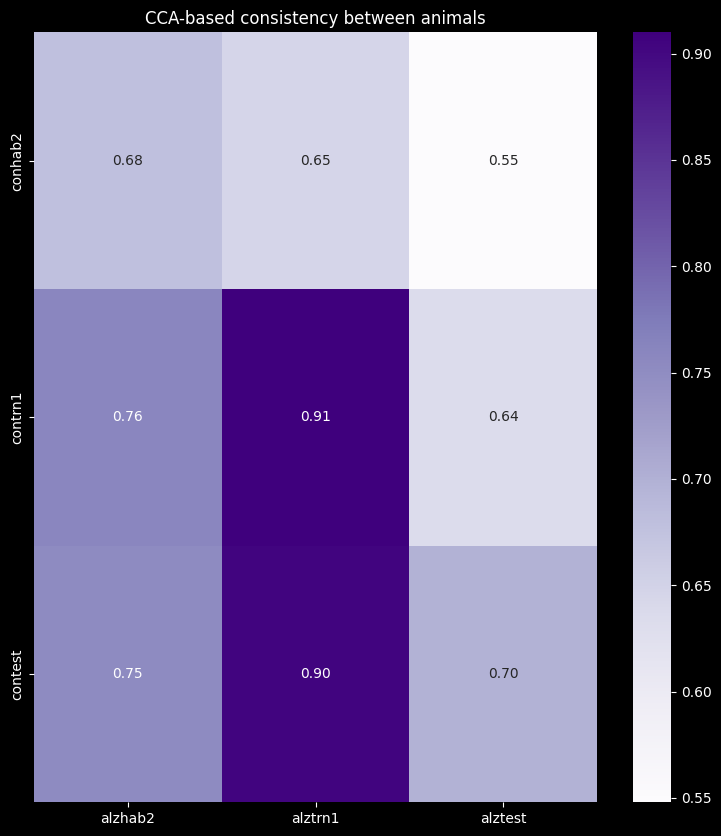

In [145]:
# Create a matrix for visualization
session_keys_ad22 = list(mean_embeddings_ad22.keys())
session_keys_ad23 = list(mean_embeddings_ad23.keys())
n_sessions_ad22 = len(session_keys_ad22)
n_sessions_ad23 = len(session_keys_ad23)

consistency_matrix_between_animals = np.zeros((n_sessions_ad22, n_sessions_ad23))

for (key1, key2), score in zip(pairs_between_animals, scores_between_animals):
    idx1 = session_keys_ad22.index(key1)
    idx2 = session_keys_ad23.index(key2)
    consistency_matrix_between_animals[idx1, idx2] = score

# Plot the consistency scores
fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121)
ax1.grid(False)

sns.heatmap(consistency_matrix_between_animals, annot=True, fmt=".2f", cmap="Purples", xticklabels=session_keys_ad23, yticklabels=session_keys_ad22, ax=ax1)
ax1.set_title("CCA-based consistency between animals")
plt.savefig('/Users/annateruel/Desktop/betweenanimals.svg', format='svg')


Visualize the data: behavior and neural activity 

In [ ]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(nd.T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), b[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.show()

In [ ]:
import os
import numpy as np
dir = '/Users/annateruel/phd_code/cebra/AD22118/'
file_list = [files for files in os.listdir(dir) if files.endswith('.pt')]
file_list = np.sort(file_list)
file_list

In [ ]:
root_directory = '/Users/annateruel/phd_code/cebra/AD22118/'
file_directories = []
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file == 'S_aligned.h5':
            # Append the directory path to the list
            file_path = os.path.join(root, file)
            file_directories.append(file_path)
calcium_file = np.sort(file_directories)
calcium_file 

root_directory = '/Users/annateruel/phd_code/cebra/AD22118/'
file_directories = []
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file == 'centroid.h5':
            # Append the directory path to the list
            file_path = os.path.join(root, file)
            file_directories.append(file_path)
beh_file = np.sort(file_directories)
beh_file 

In [ ]:
plt.style.use('dark_background')  # plots with black background
fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
axs_up = [ax1, ax2, ax3, ax4]

for session, dataset, dataset2, ax in zip(file_list, calcium_file, beh_file, axs_up):
    nd = cebra.load_data(file=dataset)
    b =  cebra.load_data(file=dataset2)

    cebra_behavior_model = cebra.CEBRA.load(session)
    embedding = cebra_behavior_model.transform(nd)

    ax=cebra.plot_embedding(ax=ax, embedding=embedding, embedding_labels=b[:,0], title=f"{session}", cmap='cebra', dpi = 100, idx_order=(1, 0, 2), figsize= (3, 3))
    plt.savefig('/Users/annateruel/Desktop/ad22118.pdf', format='pdf')

In [ ]:
embeddings_list = []
labels = []

for session, dataset, dataset2 in zip(file_list, calcium_file, beh_file):
    nd = cebra.load_data(file=dataset)
    b = cebra.load_data(file=dataset2)

    cebra_behavior_model = cebra.CEBRA.load(session)
    cebra_behavior_embedding = cebra_behavior_model.transform(nd)

    # Append the embedding to the list
    embeddings_list.append(cebra_behavior_embedding)
    labels.append(b[:,0])



In [ ]:
for i in range(4):
    if len(embeddings_list[i]) == len(labels[i]):
        print(True)
    else: 
        print(False)


In [ ]:
posdir_scores, posdir_pairs, posdir_subjects = cebra.sklearn.metrics.consistency_score(embeddings=[embeddings_list[0], embeddings_list[1]],
                                                                                       labels=[labels[0], labels[1]],
                                                                                       between="datasets")

In [ ]:
import os
import matplotlib.pyplot as plt
import cebra

plt.style.use('dark_background')  # plots with black background

# Directory containing the files
directory = '/Users/annateruel/phd_code/cebra/AD22118/'

# Iterate over the files in the directory
for filename in os.listdir(directory):
    # Check if the filename matches the structure
    if filename.startswith("cebra_behavior_model_") and filename.endswith(".pt"):
        # Load the model
        cebra_behavior_model = cebra.CEBRA.load(os.path.join(directory, filename))

        # Transform the model and save it as an embedding
        embedding = cebra_behavior_model.transform(nd)

        # Create a new figure for each file
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the embedding
        ax = cebra.plot_embedding(ax=ax, embedding=embedding, embedding_labels=b[:,0], title=f"{filename}", cmap='cebra', dpi = 100, idx_order=(1, 0, 2), figsize= (3, 3))

        # Save the figure
        plt.savefig(f'/Users/annateruel/Desktop/{filename}.pdf', format='pdf')

        # Close the figure to free up memory
        plt.close(fig)

### CEBRA-hybrid

Uses both time and positional information

In [ ]:
import numpy as np
nd = cebra.load_data(file='/Users/annateruel/Desktop/AD23-120/trn1/caiman/aligned_C.h5')
b = cebra.load_data(file='/Users/annateruel/Desktop/results_calcium/AD22118/session4/centroid.h5')

In [ ]:
max_iterations = 5000
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=0.05,
                        temperature=1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='mps',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

In [ ]:
cebra_hybrid_model.fit(nd, b)
cebra_hybrid_model.save("cebra_hybrid_model_s4.pt")

In [ ]:
cebra_hybrid_model = cebra.CEBRA.load("cebra_hybrid_model.pt")
cebra_hybrid = cebra_hybrid_model.transform(nd)


In [ ]:
cebra.plot_embedding(ax=ax1, embedding=cebra_behavior, embedding_labels=b_s4[:,1], title='CEBRA-Behavior Session1', cmap='plasma')
plt.savefig('/Users/annateruel/Desktop/your_plot.svg', format='svg')

### Grid search (hyperparameter tuning)

A grid-search is the process of performing hyperparameter tuning in order to determine the optimal values of a given model. Practically, it consists in running a model on the data, by modifying the hyperparameters values at each iteration. Then, evaluating the performances of each model allows the user to select the best set of hyperparameters for its specific data.


In [ ]:
import cebra
# 1. Define the parameters, either variable or fixed
params_grid = dict(
    output_dimension = [3,16],
    learning_rate = [0.005, 0.01, 0.05],
    time_offsets = 5,
    max_iterations = 500,
    device='mps',
    temperature_mode = "auto",
    verbose = False)

In [ ]:
datasets = {"dataset1": nd,                     
            "dataset2": (nd, b)} 

In [ ]:
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(datasets=datasets, params=params_grid, models_dir="saved_models")

In [ ]:
df_results = grid_search.get_df_results(models_dir="saved_models2")
best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset2", models_dir="saved_models2")
best_model_name